In [59]:
import requests
import os
import numpy as np

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers.core import RepeatVector
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from keras.layers import (
    Conv2D,
    UpSampling2D,
    Input,
    Reshape,
    concatenate,
)

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave

import matplotlib.pyplot as plt
import tensorflow as tf

# Create embedding
def create_inception_embedding(inception, grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')#, anti_aliasing=True)
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed


def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax


def read_img(img_id, data_dir, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    #img = image.load_img(os.path.join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.load_img(os.path.join(data_dir, train_or_test, '%s' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img


def color_result(PATH, START, END, RESULT, model, inception):
    # Make predictions on validation images
    color_me = []
    i = 0
    # Take file in range [START, END] inside the PATH folder
    for filename in os.listdir(PATH):
        if i > START and i < END:
            color_me.append(img_to_array(load_img(os.path.join(PATH, filename))))
        i += 1

    #################
    # Preprocessing #
    #################
    # From RGB to B&W and embedding
    color_me = np.array(color_me, dtype=float)
    color_me_embed = create_inception_embedding(inception, gray2rgb(rgb2gray(1.0/255*color_me)))
    color_me = rgb2lab(1.0/255*color_me)[:, :, :, 0]
    color_me = color_me.reshape(color_me.shape+(1,))

    # Test model
    output = model.predict([color_me, color_me_embed])
    # Rescale the output from [-1,1] to [-128, 128]
    output = output * 128

    # Create the result directory if not extists
    if not os.path.exists('result'):
        os.makedirs('result')

    # Output colorizations
    for i in range(len(output)):
        cur = np.zeros((256, 256, 3))
        # LAB representation
        cur[:, :, 0] = color_me[i][:, :, 0]
        cur[:, :, 1:] = output[i]
        # Save images as RGB
        imsave("result/img_"+str(i)+".png", lab2rgb(cur))

def colorize_image(loc, model, inception, show=False):
    color_me = []
    color_me.append(read_img(loc, './', 'tiny-imagenet-200/test/images', (256, 256)))

    #################
    # Preprocessing #
    #################
    # From RGB to B&W and embedding
    color_me = np.array(color_me, dtype=float)
    color_me_embed = create_inception_embedding(inception, gray2rgb(rgb2gray(1.0/255*color_me)))
    color_me = rgb2lab(1.0/255*color_me)[:, :, :, 0]
    color_me = color_me.reshape(color_me.shape+(1,))

    # Test model
    output = model.predict([color_me, color_me_embed])
    # Rescale the output from [-1,1] to [-128, 128]
    output = output * 128

    # Output colorizations
    for i in range(len(output)):
        cur = np.zeros((256, 256, 3))
        # LAB representation
        cur[:, :, 0] = color_me[i][:, :, 0]
        cur[:, :, 1:] = output[i]

    cur = resize(cur, (64, 64, 3), mode='constant')
    # B&W
    if(show == True):
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.axis('off')
        ax1.set_title('B&W')
        ax1.imshow(rgb2gray(read_img(loc, './', 'tiny-imagenet-200/test/images', (64, 64))/255), cmap='gray')

        # Prediction
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.axis('off')
        ax2.set_title('Prediction')
        ax2.imshow(lab2rgb(cur))

        # Original
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.axis('off')
        ax3.set_title('Original')
        ax3.imshow(read_img(loc, './', 'tiny-imagenet-200/test/images', (64, 64))/255)
    
    imsave("./result/%s"%(loc), lab2rgb(cur))

def prediction_from_url(url, model, inception):
    test_image_path = './panda.jpg'

    # Download the image
    response = requests.get(url)
    if response.status_code == 200:
        with open(test_image_path, 'wb') as f:
            f.write(response.content)

    color_me = []
    color_me.append(read_img('panda', './', 'tiny-imagenet-200/test/images', (256, 256)))

    #################
    # Preprocessing #
    #################
    # From RGB to B&W and embedding
    color_me = np.array(color_me, dtype=float)
    color_me_embed = create_inception_embedding(inception, gray2rgb(rgb2gray(1.0/255*color_me)))
    color_me = rgb2lab(1.0/255*color_me)[:, :, :, 0]
    color_me = color_me.reshape(color_me.shape+(1,))

    # Test model
    output = model.predict([color_me, color_me_embed])
    # Rescale the output from [-1,1] to [-128, 128]
    output = output * 128

    # Output colorizations
    for i in range(len(output)):
        cur = np.zeros((256, 256, 3))
        # LAB representation
        cur[:, :, 0] = color_me[i][:, :, 0]
        cur[:, :, 1:] = output[i]

    # B&W
    fig = plt.figure(figsize=(9, 9))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.axis('off')
    ax1.set_title('B&W')
    ax1.imshow(rgb2gray(read_img('panda', './', '', (256, 256))/255), cmap='gray')

    # Prediction
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.axis('off')
    ax2.set_title('Prediction')
    ax2.imshow(lab2rgb(cur))

    # Original
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.axis('off')
    ax3.set_title('Original')
    ax3.imshow(read_img('panda', './', '', (256, 256))/255)


def load_pretrained_model(inception_wpath, colornet_wpath):
    '''Load Emil's pretrained model'''
    #print('Loading pretrained model... (it could take a while)')

    # Load weights of InceptionResNet model for embedding extraction
    inception = InceptionResNetV2(weights=None, include_top=True)
    inception.load_weights(inception_wpath)
    inception.graph = tf.get_default_graph()

    # The Model
    def conv_stack(data, filters, s):
        """Utility for building conv layer"""
        output = Conv2D(filters, (3, 3), strides=s, activation='relu', padding='same')(data)
        return output

    embed_input = Input(shape=(1000,))

    # Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = conv_stack(encoder_input, 64, 2)
    encoder_output = conv_stack(encoder_output, 128, 1)
    encoder_output = conv_stack(encoder_output, 128, 2)
    encoder_output = conv_stack(encoder_output, 256, 1)
    encoder_output = conv_stack(encoder_output, 256, 2)
    encoder_output = conv_stack(encoder_output, 512, 1)
    encoder_output = conv_stack(encoder_output, 512, 1)
    encoder_output = conv_stack(encoder_output, 256, 1)

    # Fusion
    # y_mid: (None, 256, 28, 28)
    fusion_output = RepeatVector(32 * 32)(embed_input)
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3)
    fusion_output = Conv2D(256, (1, 1), activation='relu')(fusion_output)

    # Decoder
    decoder_output = conv_stack(fusion_output, 128, 1)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = conv_stack(decoder_output, 64, 1)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = conv_stack(decoder_output, 32, 1)
    decoder_output = conv_stack(decoder_output, 16, 1)
    decoder_output = Conv2D(2, (2, 2), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)

    model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

    # Load colornet weights
    model.load_weights(colornet_wpath)

    print('Model loaded!')
    return(model, inception)

In [1]:
import os
import sys
sys.path.append('./')

In [2]:
# Testing on url images
from ipywidgets import interact_manual
from ipywidgets import widgets
from support import load_pretrained_model

(model, inception) = load_pretrained_model('./inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5',
                      './color_tensorflow_real_mode_300.h5')


e:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Model loaded!


In [40]:
#from support import colorize_image
def get_prediction(loc):
    colorize_image(loc, model, inception)

interact_manual(get_prediction, loc=widgets.Text(placeholder='Insert URL of a pic'));

interactive(children=(Text(value='', description='loc', placeholder='Insert URL of a pic'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

e:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
e:\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
e:\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
e:\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
e:\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 6 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
e:\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: Us

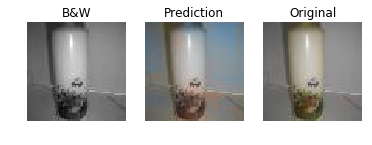

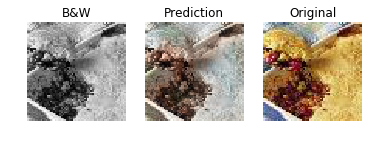

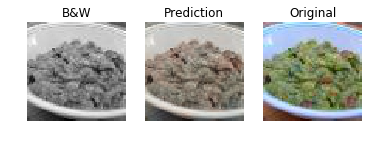

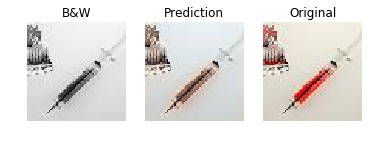

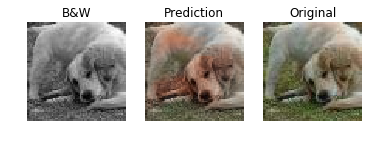

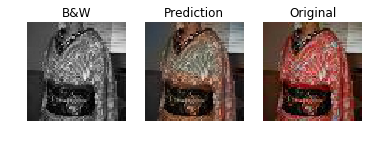

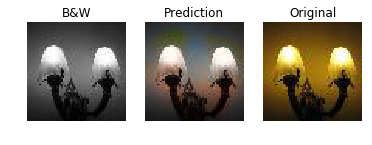

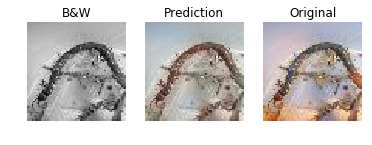

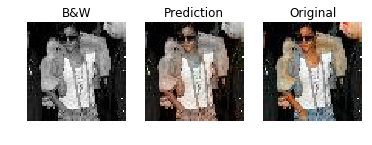

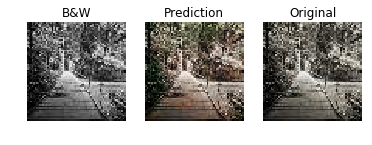

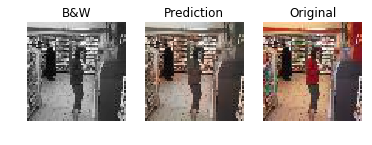

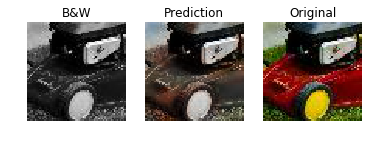

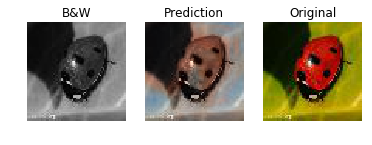

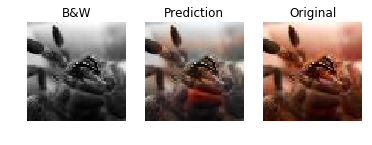

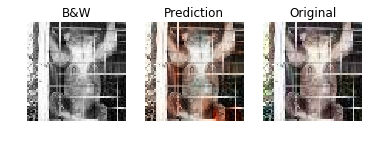

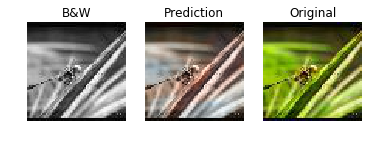

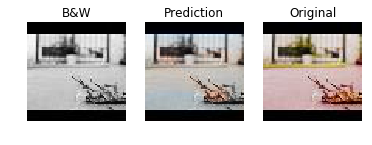

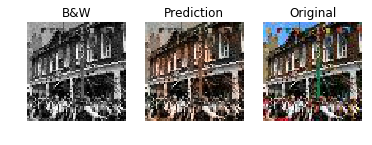

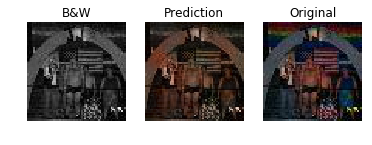

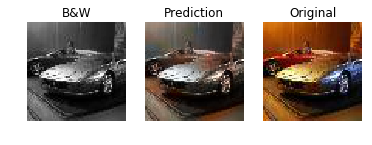

In [60]:
from os import walk
img_files = []
for (dirpath, dirnames, filenames) in walk('D:/__Road/_proj/colorize image/tiny-imagenet-200/test/images/'):
    img_files.extend(filenames)
    break

#from support import colorize_image
for idx, img in enumerate(img_files):
    if(idx < 20):
        colorize_image(img, model, inception, show=True)
    else:
        colorize_image(img, model, inception, show=False)

## Initial Setup

Let's start by importing some packages

In [ ]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np

import os
import random
import keras

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.models import Sequential, Model
from keras.callbacks import TensorBoard 

from keras.engine import Layer
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.core import RepeatVector, Permute

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave

## Training Parameters

We'll set the hyperparameters for training our model. If you understand what they mean, feel free to play around - otherwise, we recommend keeping the defaults for your first run 🙂

In [ ]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 20 # Number of examples used in each iteration
    EPOCHS = 1000 # Number of passes through entire dataset
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 20
    EPOCHS = 250

In [ ]:
DS_PATH = '/floyd/input/colornet/ds-small' # ADD path/to/dataset

# Get images
X = []
for filename in os.listdir(DS_PATH):
    if os.path.isfile(os.path.join(DS_PATH, filename)):
        X.append(img_to_array(load_img(os.path.join(DS_PATH, filename))))
                      
# Normalization => Converting pixel value from [0-255] to [0,1]                      
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X

In [ ]:
from support import create_inception_embedding

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=10,
        horizontal_flip=True)

def image_a_b_gen(batch_size):
    """Wrapper on top of ImageDataGenerator which
    converts RGB images to B&W, extract the feature using Inception,
    and get the LAB from the original image. 
    
    All this information will compose the current batch used 
    during the training."""
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        # RGB to B&W
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        # Feature Extraction
        embed = create_inception_embedding(inception, grayscaled_rgb)
        # RGB to LAB
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        # Convert LAB value from [-128, 128] to [-1, 1]
        Y_batch = lab_batch[:,:,:,1:] / 128
        # The new Batch (B&W, Embedding, LAB)
        yield ([X_batch, create_inception_embedding(inception, grayscaled_rgb)], Y_batch)

In [ ]:
#Load weights of InceptionResNet model for embedding extraction 
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('/floyd/input/colornet/models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

In [ ]:
# The Model
def conv_stack(data, filters, s):
    """Utility for building conv layer"""
    output = Conv2D(filters, (3, 3), strides=s, activation='relu', padding='same')(data)
    return output

embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = conv_stack(encoder_input, 64, 2)
encoder_output = conv_stack(encoder_output, 128, 1)
encoder_output = conv_stack(encoder_output, 128, 2)
encoder_output = conv_stack(encoder_output, 256, 1)
encoder_output = conv_stack(encoder_output, 256, 2)
encoder_output = conv_stack(encoder_output, 512, 1)
encoder_output = conv_stack(encoder_output, 512, 1)
encoder_output = conv_stack(encoder_output, 256, 1)

#Fusion
# y_mid: (None, 256, 28, 28)
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu')(fusion_output) 



#Decoder
decoder_output = conv_stack(fusion_output, 128, 1)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = conv_stack(decoder_output, 64, 1)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = conv_stack(decoder_output, 32, 1)
decoder_output = conv_stack(decoder_output, 16, 1)
decoder_output = Conv2D(2, (2, 2), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model.summary()

In [ ]:
#Train model 
tensorboard = TensorBoard(log_dir="/floyd/home/run")
model.compile(optimizer='adam', loss='mse')
model.fit_generator(image_a_b_gen(BATCH_SIZE), 
                    callbacks=[tensorboard], 
                    epochs=EPOCHS, steps_per_epoch=1)

### Eval

We will use the images in the range [START, END] of the Train for evaluating our model as Emil did during his experiments.

In [ ]:
# Eval Colorization
from support import color_result

START = 0
END = 100
PATH = '/floyd/input/colornet/ds-big/Train/'
RESULT = 'result'

# It could take some minutes on CPU
color_result(PATH, START, END, RESULT, model, inception)

In [ ]:
# Show results

from ipywidgets import interact
from ipywidgets import widgets
from support import show_img 

def show_sample(sample_n):
    image_path = os.path.join(RESULT, "img_"+str(sample_n-1)+".png")
    img = image.load_img(image_path)
    img = image.img_to_array(img)/255
    ax = show_img(img, figsize=(9,9))
    ax.set_title(image_path)
    
interact(show_sample, sample_n=widgets.IntSlider(value=1, min=1, max=END-START-1, description='Show results of colorization'));

In [ ]:
# Testing on url images
from ipywidgets import interact_manual
from ipywidgets import widgets
from support import prediction_from_url

def get_prediction(URL):
    prediction_from_url(URL, model, inception)

interact_manual(get_prediction, URL=widgets.Text(placeholder='Insert URL of a pic'));

## Save the result

In [ ]:
model.save_weights("models/color_tensorflow_ds_small_{}.h5".format(EPOCHS))